In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Análisis Exploratorio de datos (EDA)

In [11]:
results_df = pd.read_csv('../results/execution_time.csv')
results_df.head(2)

,total_time,total_cpu_usage,max_ram_usage,brand_raw,vendor_id_raw,arch,count,l2_cache_size,l3_cache_size,hz_actual_friendly,hz_advertised_friendly,l2_cache_line_size,l2_cache_associativity,benchmark
0,13.49,99%,1470312,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,GenuineIntel,X86_64,12,1.5 MiB,12582912,4.0996 GHz,2.9000 GHz,256,6,KNP
1,13.32,99%,1470608,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,GenuineIntel,X86_64,12,1.5 MiB,12582912,4.0996 GHz,2.9000 GHz,256,6,KNP


In [12]:
results_savio_df = pd.read_csv('../results_savio/execution_time.csv')
results_savio_df.head(2)

,total_time,total_cpu_usage,max_ram_usage,brand_raw,vendor_id_raw,arch,count,l2_cache_size,l3_cache_size,hz_actual_friendly,hz_advertised_friendly,l2_cache_line_size,l2_cache_associativity,benchmark
0,20.81,98%,1466524,Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz,GenuineIntel,X86_64,24,6291456,31457280,1.2000 GHz,2.3000 GHz,256,6,KNP
1,21.05,99%,1465000,Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz,GenuineIntel,X86_64,24,6291456,31457280,1.2000 GHz,2.3000 GHz,256,6,KNP


In [13]:
results_df = pd.concat([results_df, results_savio_df], ignore_index=True)
# preprocessing
results_df['total_cpu_usage'] = results_df['total_cpu_usage'].str.replace('%', '').astype(float) / 100
results_df['max_ram_usage'] = results_df['max_ram_usage'] / np.power(1024,2)
results_df['l2_cache_size_mb'] = results_df['l2_cache_size'].str.replace(' MiB', '').astype(float)
results_df['l3_cache_size_mb'] = results_df['l3_cache_size'] / np.power(1024,2)
results_df['ghz_actual_friendly'] = results_df['hz_actual_friendly'].str.replace('GHz', '').str.replace('MHz', '').astype(float)
results_df['ghz_advertised_friendly'] = results_df['hz_advertised_friendly'].str.replace('GHz', '').astype(float)
results_df = results_df.drop(columns=['hz_actual_friendly', 'hz_advertised_friendly','l2_cache_size','l3_cache_size'])

## PC's utilizados

In [5]:
# Count = Threads
results_df[['brand_raw','vendor_id_raw','arch','count']].drop_duplicates()

,brand_raw,vendor_id_raw,arch,count
0,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,GenuineIntel,X86_64,12
20,Intel(R) Xeon(R) CPU E5-2670 v3 @ 2.30GHz,GenuineIntel,X86_64,24
40,Intel(R) Xeon(R) CPU E5-2623 v3 @ 3.00GHz,GenuineIntel,X86_64,8
60,Intel(R) Xeon(R) Gold 6230 CPU @ 2.10GHz,GenuineIntel,X86_64,40
80,Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz,GenuineIntel,X86_64,56


## Benchmarks

### Matrix multiplication (5000x5000)

In [6]:
mm_df = results_df[results_df['benchmark']=='MATRIX_MULT']

In [7]:
# total_memory_usage and swaps are not available for containerized benchmarks
mm_df[['total_time','total_cpu_usage','max_ram_usage']].describe()

,total_time,total_cpu_usage,max_ram_usage
count,25.000000,25.000000,25.000000
mean,10.310000,11.860800,2.309527
std,8.767718,7.443751,0.025928
min,3.580000,1.920000,2.278027
25%,4.420000,7.600000,2.292431
50%,5.080000,10.770000,2.310352
75%,11.840000,15.290000,2.324581
max,26.660000,24.310000,2.395359


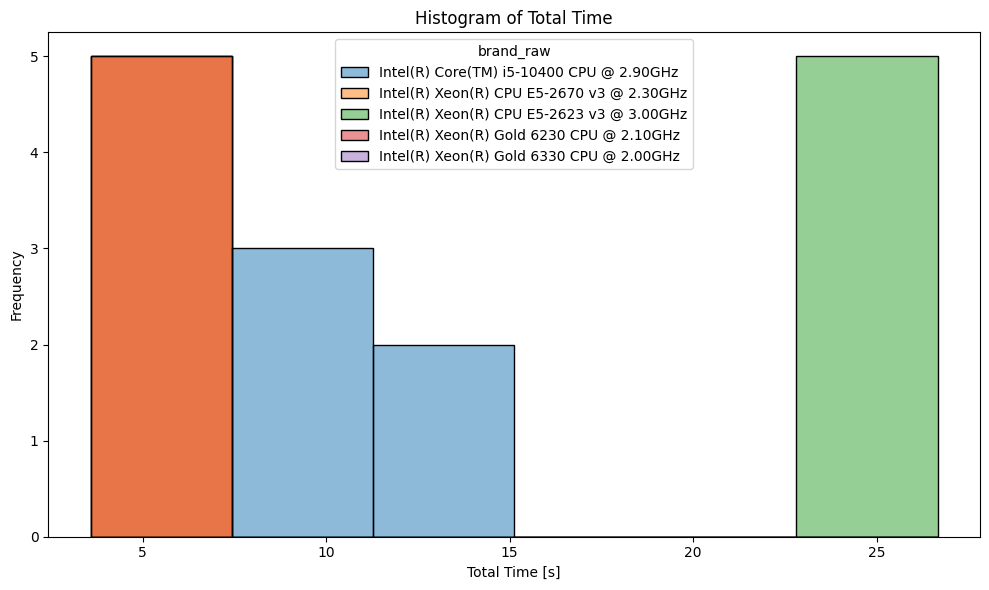

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(mm_df, x='total_time', hue='brand_raw')
plt.title('Histogram of Total Time')
plt.xlabel('Total Time [s]')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

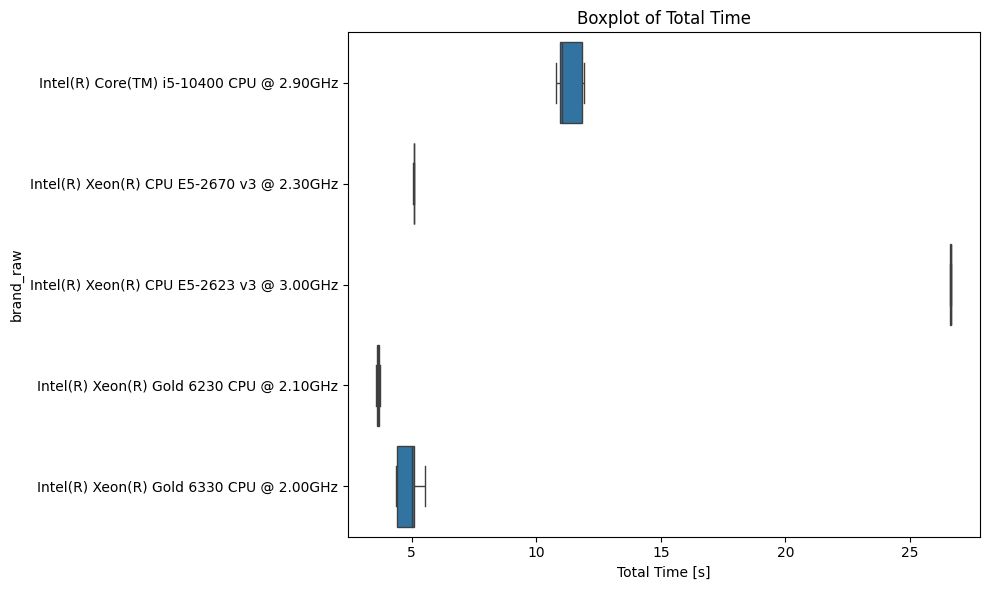

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=mm_df, x='total_time', y='brand_raw')
plt.title('Boxplot of Total Time')
plt.xlabel('Total Time [s]')

plt.tight_layout()
plt.show()

Se puede observar que la distribución del tiempo de ejecución varia bastante dependiendo del procesador usado, una relación bastante trivial. 

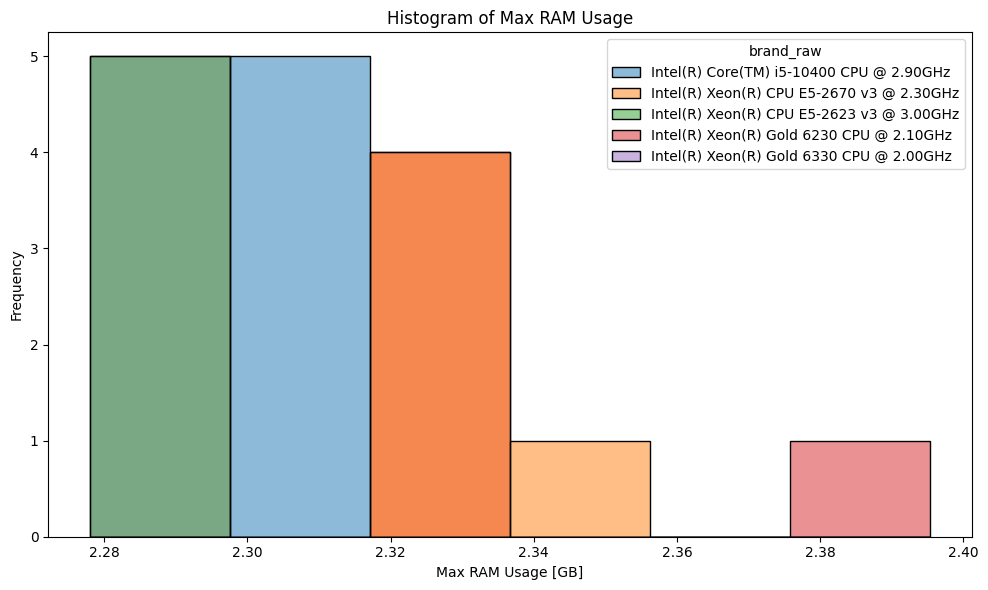

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(mm_df, x='max_ram_usage', hue='brand_raw')
plt.title('Histogram of Max RAM Usage')
plt.xlabel('Max RAM Usage [GB]')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

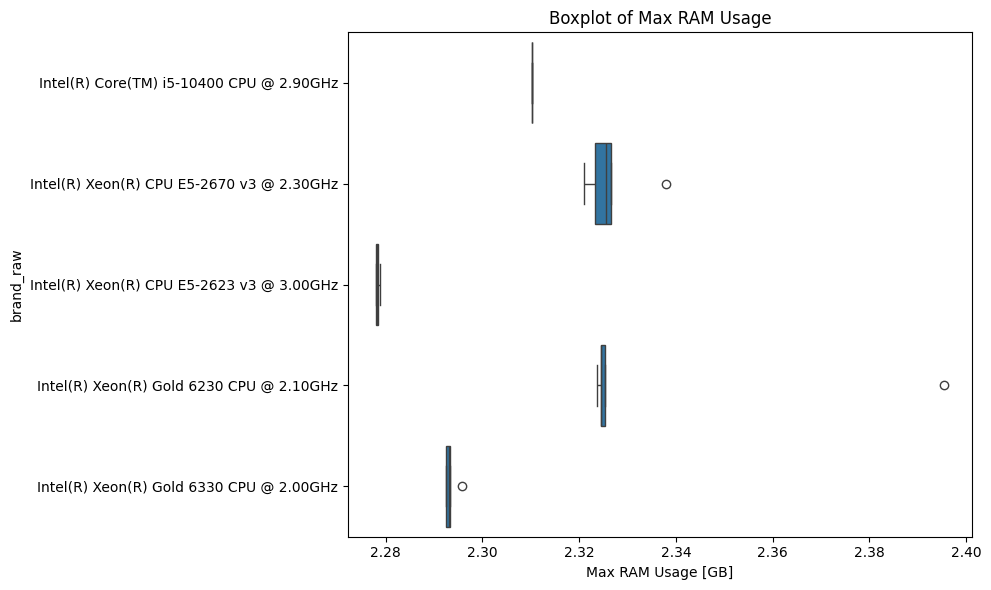

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=mm_df, x='max_ram_usage', y='brand_raw')
plt.title('Boxplot of Max RAM Usage')
plt.xlabel('Max RAM Usage [GB]')

plt.tight_layout()
plt.show()

Se puede observar que la RAM maxima utilizada no cambia, esto debido a que la cantidad de memoria utilizada es inherente del programa, al menos en este benchmark.

Ahora se profundizara en las correlaciones entre las variables medidas en la ejecución y las características de los procesadores para poder entender los atributos que más influyen, en especifico se analizará en el tiempo de ejecución.

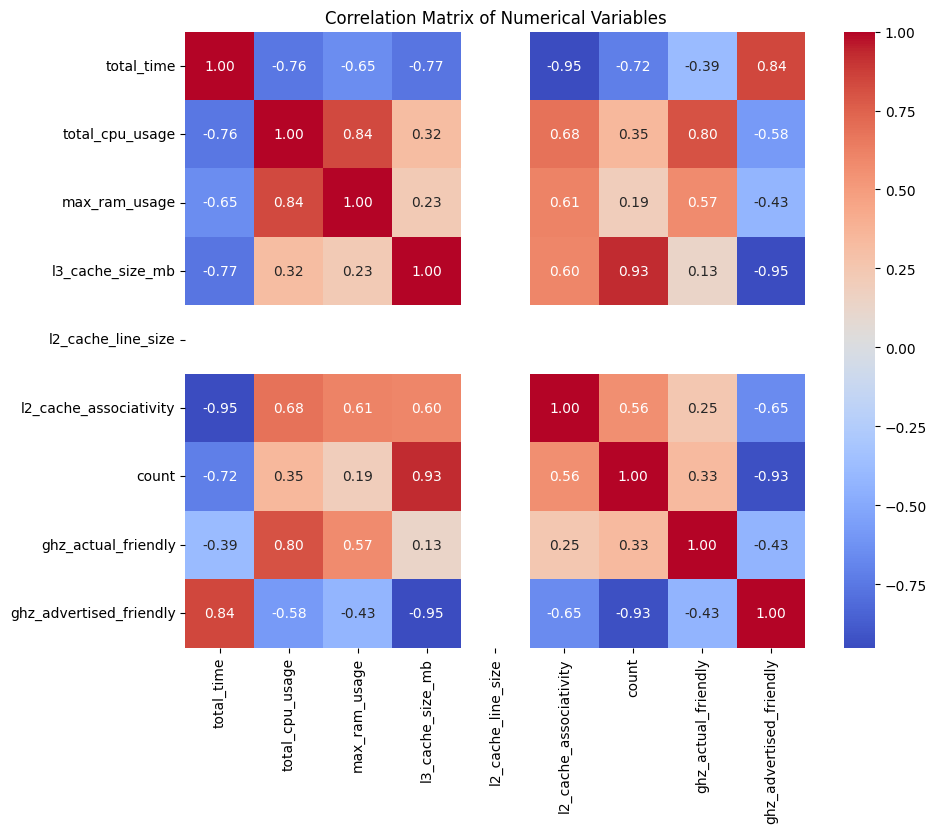

In [12]:
correlation_matrix = mm_df[['total_time', 'total_cpu_usage', 'max_ram_usage', 'l3_cache_size_mb', 'l2_cache_line_size', 'l2_cache_associativity','count','ghz_actual_friendly','ghz_advertised_friendly']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

Hay dos puntos a tener en cuenta, con lo mostrado en el mapa de correlaciones:

- **No linealidad**: La correlación entre las variables y el tiempo de ejecución no es lineal de manera general, por lo que un modelo lineal no sería suficiente para capturar la relación entre las variables y el tiempo de ejecución, como en los casos de alta correlación negativa entre `l2_cache_associativity` y `total_time` o alta correlación positiva entre `total_cpu_usage` y `total_time` u otras correlaciones moderadas que sugieren que las relaciones no son estrictamente lineales. Métodos como random forest pueden capturar relaciones no lineales hasta cierto punto, pero pueden volverse demasiado complejos o ineficientes.

- **Multicolinealidad**:  La alta correlación entre variables independientes (como `total_cpu_usage` y `count` con un valor de 0.99), puede causar problemas en una regresión lineal. Esto puede hacer que las estimaciones sean inestables y difíciles de interpretar. Métodos tradicionales podrían requerir un preprocesamiento de las variables para manejar la multicolinealidad (como PCA), lo que añade complejidad al modelo y puede hacerlo menos interpretable.

Aún con los datos obtenidos, muchos procesos computacionales son afectados por factores que pueden no estar directamente medidos o incluidos en el dataset, como variaciones en la carga de trabajo que no se capturan completamente con las variables disponibles, o algunos que se pudieran incluir a futuro como condiciones térmicas, voltaje o incluso las llamadas al sistema que ejecuta el programa.

Las interacciones entre variables, como la combinación de tipo de arquitectura y tamaño de cache, pueden tener efectos importantes en el tiempo total que no son capturables mediante una simple regresión lineal.

Para esto, los modelos de *deep learning* podrían ofrecer mejoras significativas en la predicción de `total_time` como la capacidad de manejar no linealidad, multicolinealidad, interacciones complejas y la posible incorporación de variables categóricas mediante embeddings, incluyendo las **llamadas al sistema** teniendo asi un mayor conocimiento sobre el comportamiento del programa, proporcionando así un modelo más robusto y preciso para predecir **total_time**.

 Ahora se procederá a realizar un análisis de componentes principales para reducir la dimensionalidad de los datos y poder visualizar mejor las relaciones entre las variables, además de poder identificar posibles grupos de variables que puedan ser usadas para modelar el tiempo de ejecución.

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(mm_df[
    ['total_cpu_usage', 'max_ram_usage', 'l3_cache_size_mb', 'l2_cache_line_size', 'l2_cache_associativity','count','ghz_actual_friendly','ghz_advertised_friendly']
])
pca = PCA(n_components=0.99)  # 99% of varianze
principal_components = pca.fit_transform(scaled_data)
explained_variance = pca.explained_variance_ratio_

pca_df = pd.DataFrame(data=principal_components, columns=[f"PC{i+1}" for i in range(principal_components.shape[1])])

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Individual explained variance')
plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', color='magenta', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Explained Variance by PCA Components')
plt.legend(loc='best')
plt.show()

print(f"PC1: {explained_variance[0]} | PC2: {explained_variance[1]} | PC3: {explained_variance[2]}") 

Los componentes principales resultantes capturan:
- **PC1**: 54.62% de la varianza total.
- **PC2**: 33.9% de la varianza total.
- **PC3**: 11.38% de la varianza total.

Con estos tres primeros componentes, retenemos aproximadamente el 99% de la varianza total, por casi toda la información ha sido conservada al realizar la reducción.

Ahora se visualizará la importancia de las variables en cada componente principal, para poder identificar las variables que más influyen en el tiempo de ejecución.

In [ ]:
components = pca.components_
num_components = components.shape[0]
features = ['total_cpu_usage', 'max_ram_usage', 'l3_cache_size_mb', 'l2_cache_line_size', 'l2_cache_associativity','count','ghz_actual_friendly','ghz_advertised_friendly']

for i in range(num_components):
    plt.figure(figsize=(10, 6))
    component = components[i]
    colors = ['red' if val < 0 else 'green' for val in component]
    plt.barh(features, component, color=colors)
    plt.ylabel('Weight')
    plt.title(f'Weights PCA{i+1}')
    plt.show()

Los pesos para cada componente principal nos dicen cómo contribuye cada variable original a ese componente:
- Pesos positivos o negativos altos indican una fuerte influencia de la variable en ese componente.
- Pesos cercanos a cero indican una baja influencia.
Estos componentes principales pueden ser utilizados como entradas para los modelos predictivos de `total_time`.

Notar que en el componente principal 3 la variable `max_ram_usage` destaca como la más importante, lo que sugiere que la cantidad de memoria utilizada es un factor importante en el tiempo de ejecución, al menos en aproximadamente un 11.38% de la varianza total. En los otros componentes principales, las variables tienen pesos más equilibrados, lo que sugiere que la influencia de las variables más equitativa.

### Knapsack problem

In [14]:
knp_df = results_df[results_df['benchmark']=='KNP']

In [15]:
knp_df[['total_time','total_cpu_usage','max_ram_usage']].describe()

,total_time,total_cpu_usage,max_ram_usage
count,25.00000,25.000000,25.000000
mean,17.86720,0.988800,1.399826
std,2.91288,0.003317,0.001579
min,13.32000,0.980000,1.397133
25%,16.03000,0.990000,1.398796
50%,17.88000,0.990000,1.399460
75%,20.94000,0.990000,1.400764
max,21.11000,0.990000,1.402508


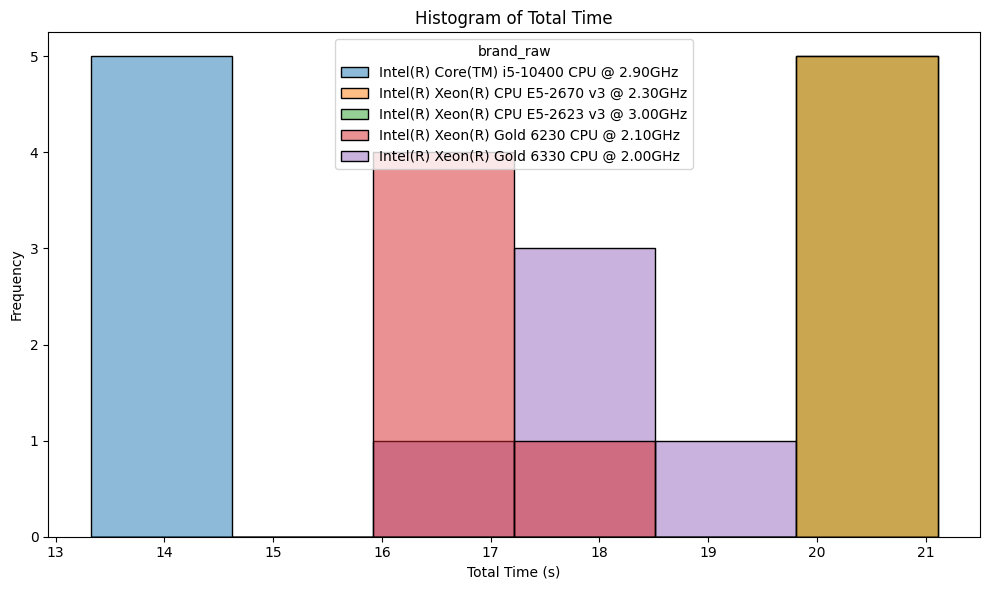

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(knp_df, x='total_time', hue='brand_raw')
plt.title('Histogram of Total Time')
plt.xlabel('Total Time (s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

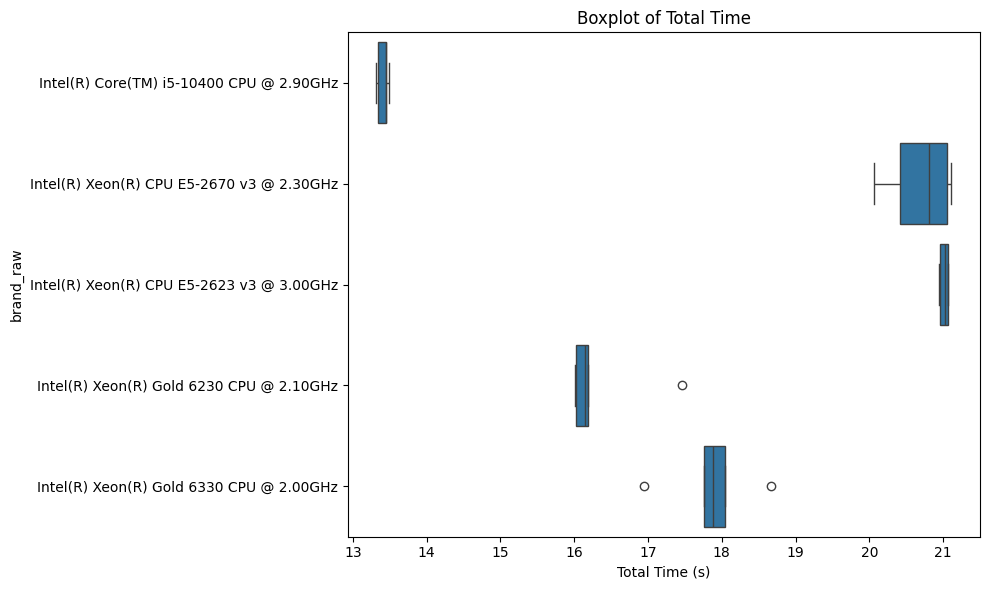

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=knp_df, x='total_time', y='brand_raw')
plt.title('Boxplot of Total Time')
plt.xlabel('Total Time (s)')

plt.tight_layout()
plt.show()

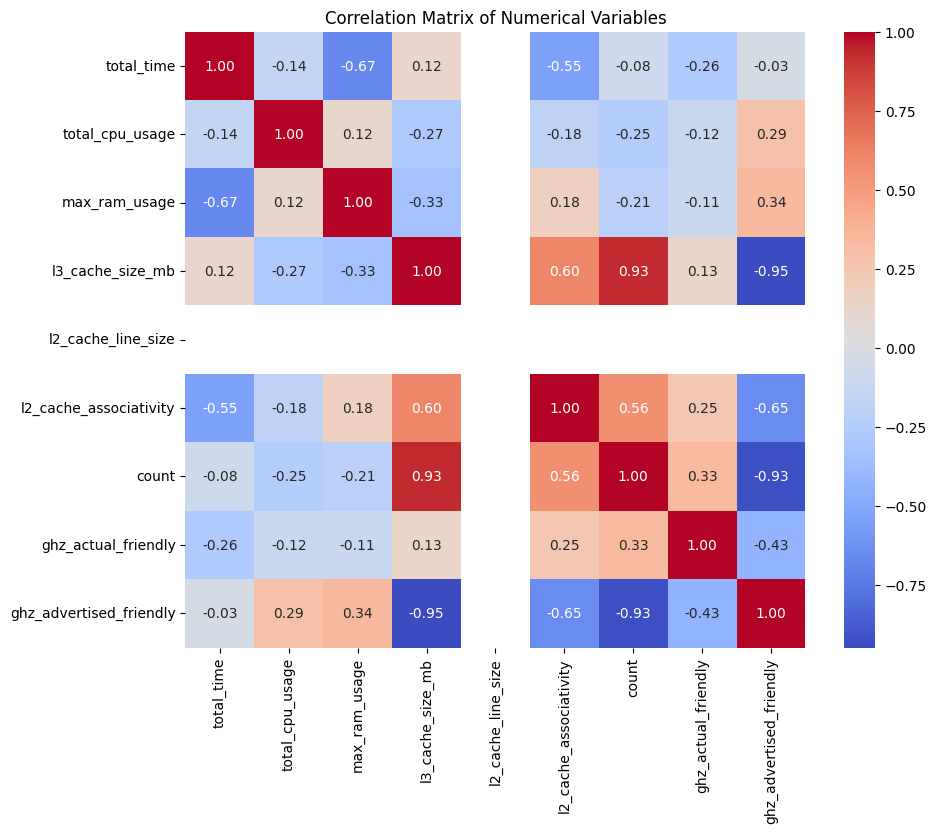

In [18]:
# Calculate correlation matrix for numerical variables
correlation_matrix = knp_df[['total_time', 'total_cpu_usage', 'max_ram_usage', 'l3_cache_size_mb', 'l2_cache_line_size', 'l2_cache_associativity','count','ghz_actual_friendly','ghz_advertised_friendly']].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

### N-Queens problem

In [30]:
nq_df = results_df[results_df['benchmark']=='N_Queens']

In [31]:
nq_df[['total_time','total_cpu_usage','max_ram_usage']].describe()

,total_time,total_cpu_usage,max_ram_usage
count,25.000000,2.500000e+01,25.000000
mean,21.901200,9.900000e-01,0.010952
std,2.947427,1.133117e-16,0.002012
min,17.470000,9.900000e-01,0.009960
25%,19.190000,9.900000e-01,0.009968
50%,23.820000,9.900000e-01,0.009968
75%,24.120000,9.900000e-01,0.009972
max,24.800000,9.900000e-01,0.015137


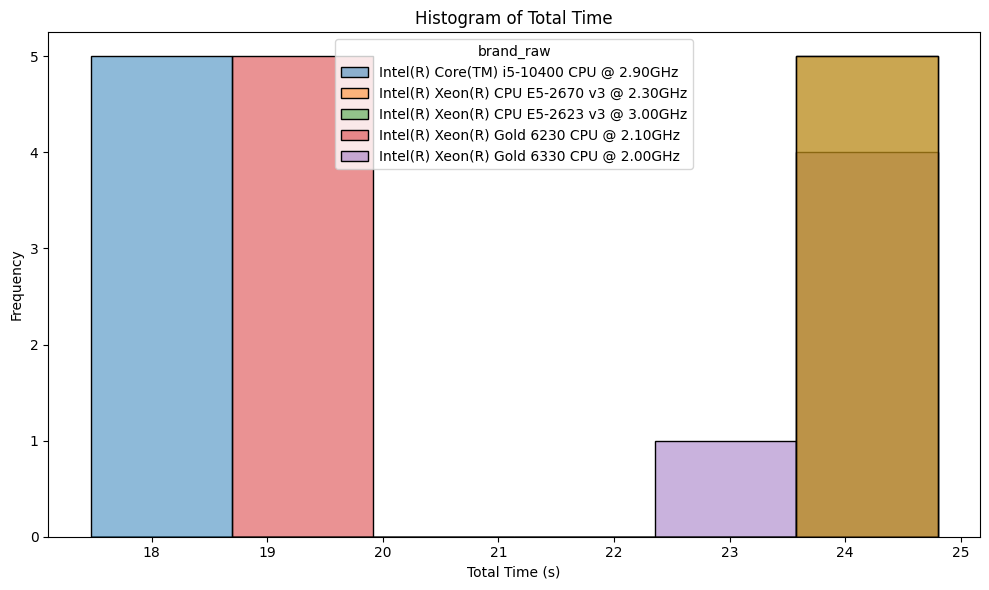

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(nq_df, x='total_time', hue='brand_raw')
plt.title('Histogram of Total Time')
plt.xlabel('Total Time (s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

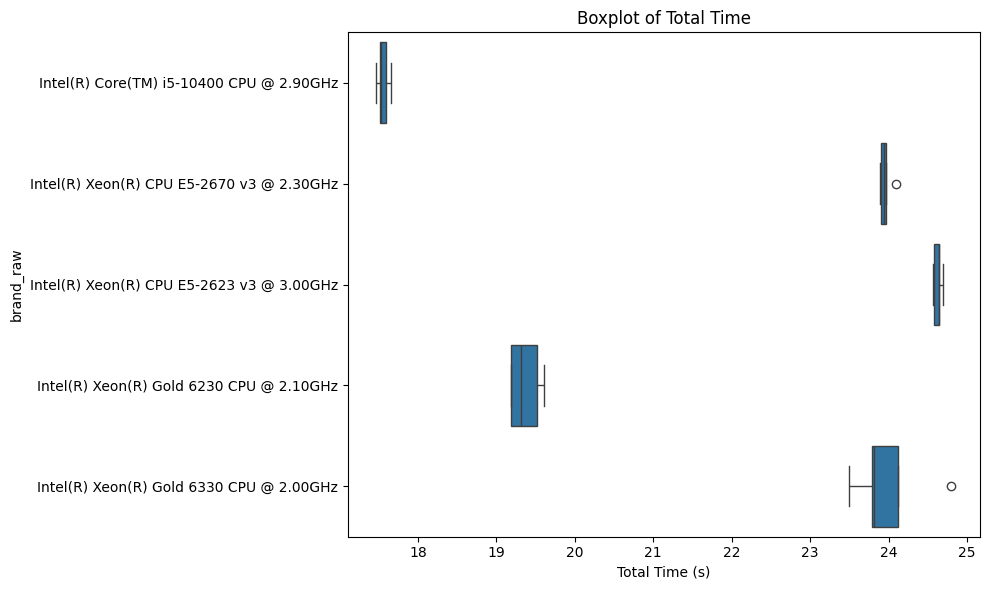

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=nq_df, x='total_time', y='brand_raw')
plt.title('Boxplot of Total Time')
plt.xlabel('Total Time (s)')

plt.tight_layout()
plt.show()

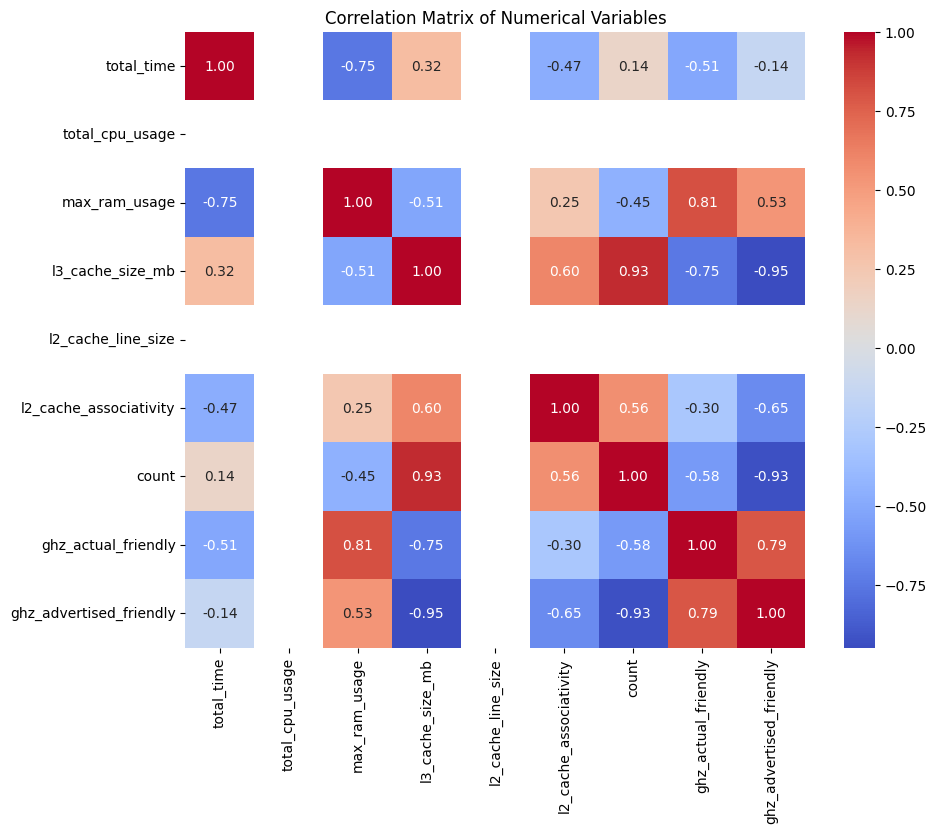

In [23]:
# Calculate correlation matrix for numerical variables
correlation_matrix = nq_df[['total_time', 'total_cpu_usage', 'max_ram_usage', 'l3_cache_size_mb', 'l2_cache_line_size', 'l2_cache_associativity','count','ghz_actual_friendly','ghz_advertised_friendly']].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

### Travelling Salesman problem

In [24]:
tsp_df = results_df[results_df['benchmark']=='N_Queens']

In [25]:
tsp_df[['total_time','total_cpu_usage','max_ram_usage']].describe()

,total_time,total_cpu_usage,max_ram_usage
count,25.000000,2.500000e+01,25.000000
mean,21.901200,9.900000e-01,0.010952
std,2.947427,1.133117e-16,0.002012
min,17.470000,9.900000e-01,0.009960
25%,19.190000,9.900000e-01,0.009968
50%,23.820000,9.900000e-01,0.009968
75%,24.120000,9.900000e-01,0.009972
max,24.800000,9.900000e-01,0.015137


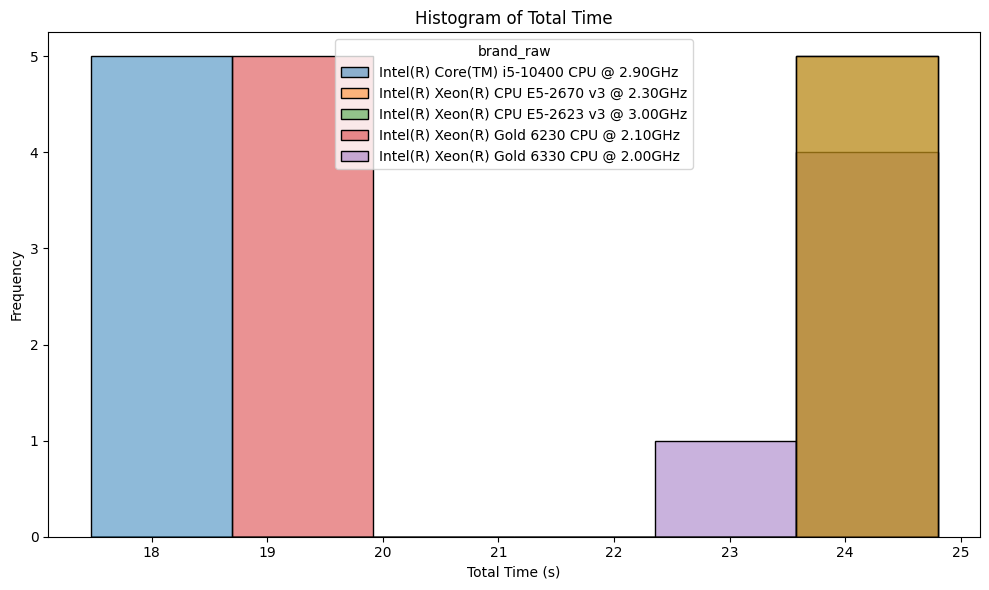

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(tsp_df, x='total_time', hue='brand_raw')
plt.title('Histogram of Total Time')
plt.xlabel('Total Time (s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

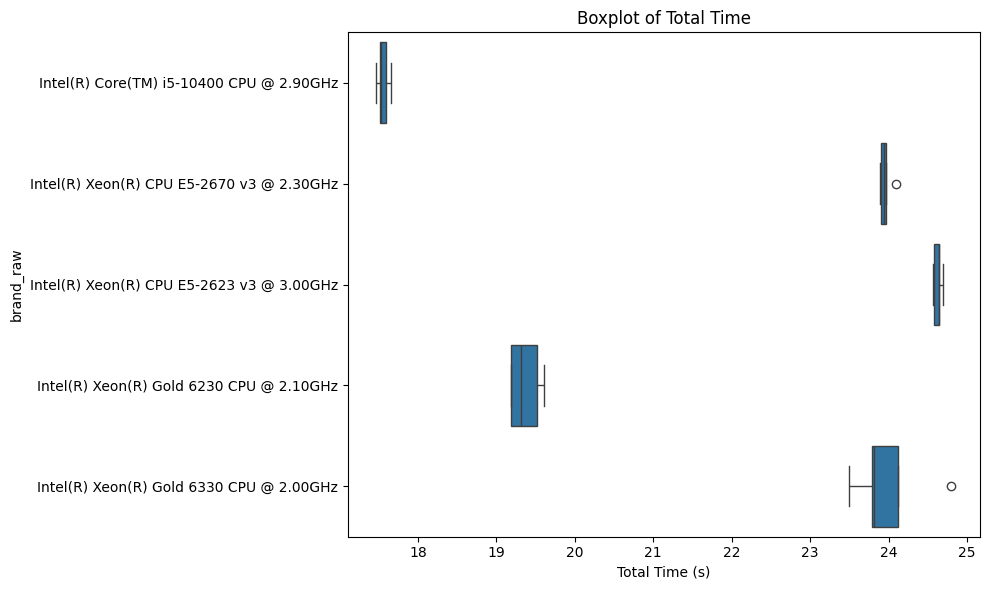

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=tsp_df, x='total_time', y='brand_raw')
plt.title('Boxplot of Total Time')
plt.xlabel('Total Time (s)')

plt.tight_layout()
plt.show()

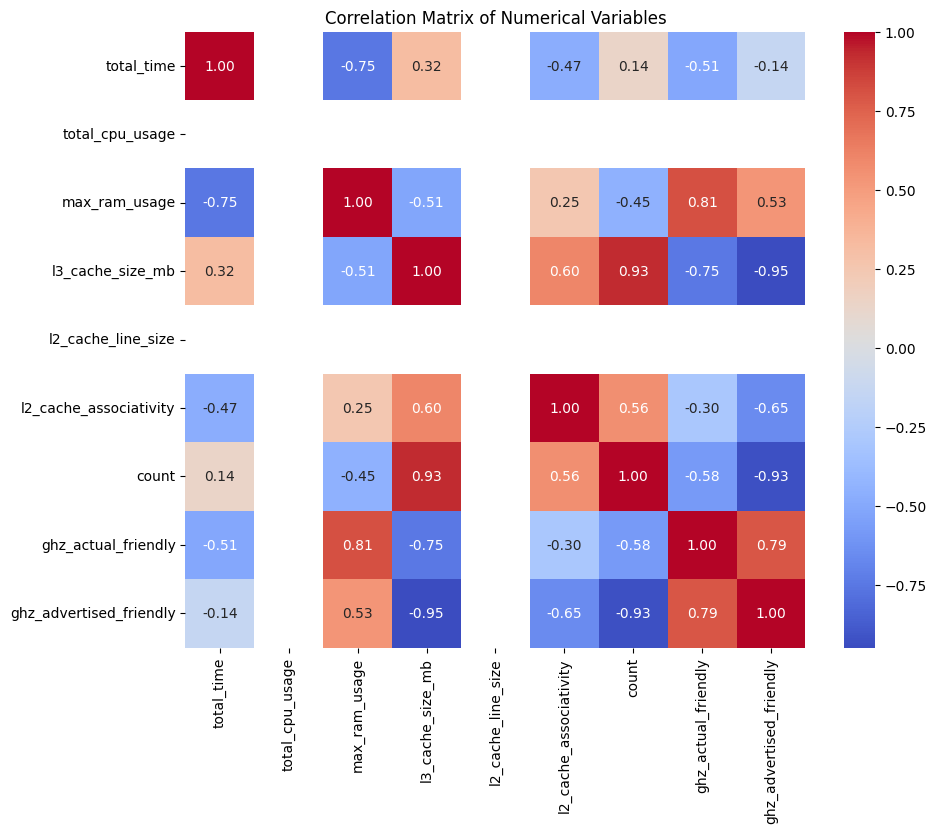

In [28]:
# Calculate correlation matrix for numerical variables
correlation_matrix = tsp_df[['total_time', 'total_cpu_usage', 'max_ram_usage', 'l3_cache_size_mb', 'l2_cache_line_size', 'l2_cache_associativity','count','ghz_actual_friendly','ghz_advertised_friendly']].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()